In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install geopandas rasterio folium -q

In [ ]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import folium
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask

In [ ]:
import geopandas as gpd
from shapely.geometry import box

phuket = gpd.GeoDataFrame(
    geometry=[box(98.15,7.75,98.5,8.2)],
    crs="EPSG:4326"
)

phuket

,geometry
0,"POLYGON ((98.5 7.75, 98.5 8.2, 98.15 8.2, 98.1..."


In [ ]:
import rasterio

rgb = rasterio.open('/content/drive/MyDrive/Phuket_SEN2/Phuket_01012024_30042024_RGB.tif')
ndvi = rasterio.open('/content/drive/MyDrive/Phuket_SEN2/Phuket_01012024_30042024_NDVI.tif')
dem = rasterio.open('/content/drive/MyDrive/Phuket_SEN2/Phuket_01012024_30042024_DEM.tif')

In [89]:
print("RGB CRS:", rgb.crs)
print("Resolution:", rgb.res)
print("Band count:", rgb.count)

RGB CRS: EPSG:4326
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Band count: 3


In [92]:
import pandas as pd
from shapely.geometry import Point

df_points = pd.DataFrame({
    'name': ['Phuket City', 'Patong Beach', 'Phuket Airport'],
    'lat': [7.8900, 7.8964, 8.1111],
    'lon': [98.3983, 98.2965, 98.3065]
})
points = gpd.GeoDataFrame(df_points, geometry=gpd.points_from_xy(df_points.lon, df_points.lat), crs="EPSG:4326")

In [93]:
import geopandas as gpd

phuket = gpd.read_file(
'/content/drive/MyDrive/Phuket_SEN2/phuket_boundary.geojson'
)

phuket

,id,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng,geometry
0,0000000000000000015c,240,Thailand,2898,Phuket,NO,3000,Member State,1000,0.044351,2.381742,"MULTIPOLYGON (((98.44498 7.95719, 98.44508 7.9..."


In [ ]:
m = folium.Map(location=[7.9,98.3], zoom_start=10)
folium.GeoJson(phuket).add_to(m)
m

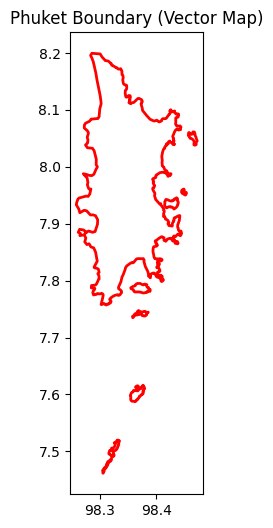

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

phuket.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2
)

plt.title("Phuket Boundary (Vector Map)")
plt.show()

In [94]:
from rasterio.mask import mask

phuket_proj = phuket.to_crs(rgb.crs)

geoms = phuket_proj.geometry.values

clipped, transform = mask(rgb, geoms, crop=True)

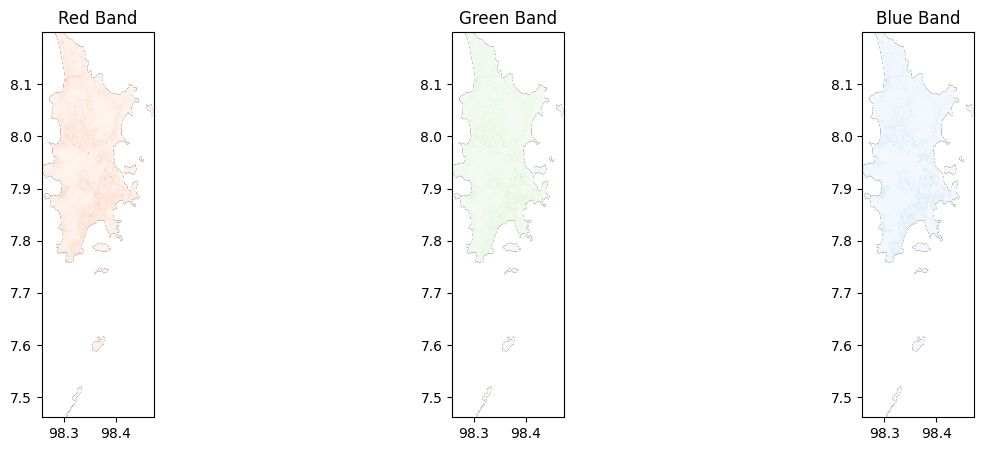

In [95]:
from rasterio.plot import show
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,5))

show((rgb,1), ax=ax[0], cmap='Reds')
ax[0].set_title('Red Band')

show((rgb,2), ax=ax[1], cmap='Greens')
ax[1].set_title('Green Band')

show((rgb,3), ax=ax[2], cmap='Blues')
ax[2].set_title('Blue Band')

plt.show()

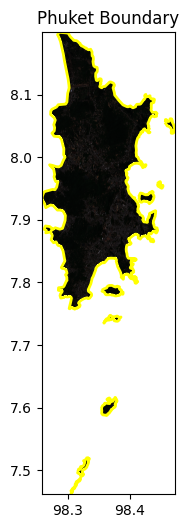

In [ ]:
from rasterio.plot import show
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

show(rgb, ax=ax)
phuket.boundary.plot(ax=ax, edgecolor="yellow", linewidth=2)

plt.title("Phuket Boundary")
plt.show()

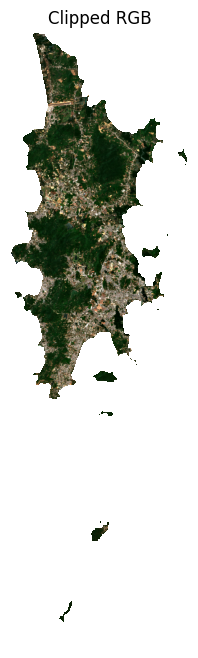

In [ ]:
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

r = clipped[0]
g = clipped[1]
b = clipped[2]

rgb_stack = np.dstack((r,g,b))

mask_black = np.all(rgb_stack <= 0, axis=2)
rgb_stack = rgb_stack.astype(float)
rgb_stack[mask_black] = np.nan

p2, p98 = np.nanpercentile(rgb_stack, (2,98))
rgb_norm = np.clip((rgb_stack - p2) / (p98 - p2), 0, 1)

plt.figure(figsize=(6,8))
plt.imshow(rgb_norm)
plt.title("Clipped RGB")
plt.axis('off')
plt.show()

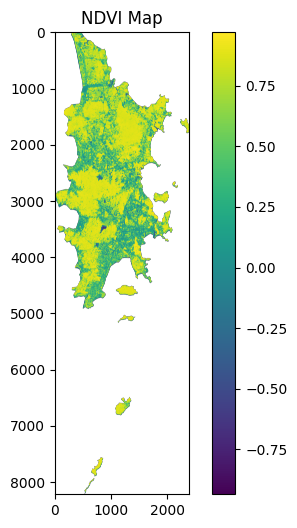

In [ ]:
import numpy as np

ndvi_arr = ndvi.read(1)

plt.figure(figsize=(6,6))
plt.imshow(ndvi_arr)
plt.title("NDVI Map")
plt.colorbar()
plt.show()

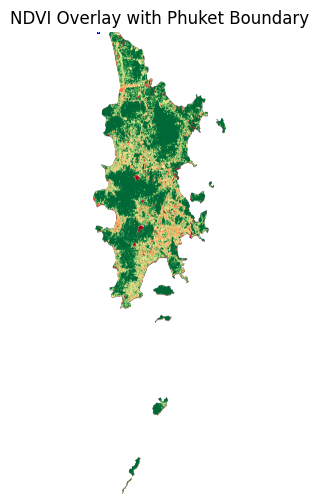

In [112]:
fig, ax = plt.subplots(figsize=(6,6))

plt.imshow(ndvi_arr, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
phuket_proj.boundary.plot(ax=ax, edgecolor="blue", linewidth=2)

plt.title("NDVI Overlay with Phuket Boundary")
plt.axis('off')
plt.show()

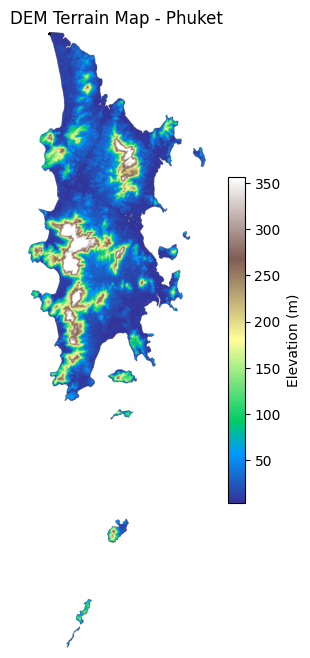

In [116]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

dem_raster = rasterio.open(
    '/content/drive/MyDrive/Phuket_SEN2/Phuket_01012024_30042024_DEM.tif'
)

dem_arr = dem_raster.read(1).astype(float)
dem_arr[dem_arr <= 0] = np.nan

fig, ax = plt.subplots(figsize=(6,8))

img = ax.imshow(
    dem_arr,
    cmap='terrain',
    vmin=np.nanpercentile(dem_arr,2),
    vmax=np.nanpercentile(dem_arr,98)
)

phuket_proj = phuket.to_crs(dem_raster.crs)
phuket_proj.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.5
)

plt.title("DEM Terrain Map - Phuket")
plt.axis('off')

cbar = plt.colorbar(img, ax=ax, fraction=0.035)
cbar.set_label("Elevation (m)")

plt.show()

In [115]:
import numpy as np

print("NDVI Mean:", np.nanmean(ndvi_arr))
print("NDVI Min:", np.nanmin(ndvi_arr))
print("NDVI Max:", np.nanmax(ndvi_arr))

NDVI Mean: 0.6127288
NDVI Min: -0.9354839
NDVI Max: 0.97033286


In [101]:
import geopandas as gpd
from shapely.geometry import Point

data = {
    'name': [
        'Municipal Health Center 1 (PCD 35t)',
        'Sansiri - The Deck Patong',            # โซนป่าตอง (Private)
        'UWC Thailand International School',    # โซนถลาง (PurpleAir)
        'Chalong Circle Station',               # โซนห้าแยกฉลอง (CMU CCDC)
        'Phuket City Incinerator',              # โซนศูนย์กำจัดขยะ (CUSense)
        'Choeng Thale Health Center'            # โซนเชิงทะเล
    ],
    'type': ['Official', 'Private', 'Community', 'Community', 'University', 'Community']
}

geometry = [
    Point(98.3923, 7.8804),   # Phuket Town
    Point(98.3000, 7.8900),   # Patong
    Point(98.3000, 8.0200),   # Thalang (North)
    Point(98.3421, 7.8206),   # Chalong (South)
    Point(98.4000, 7.8590),   # Saphan Hin Area
    Point(98.3030, 7.9850)    # Choeng Thale
]

points = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

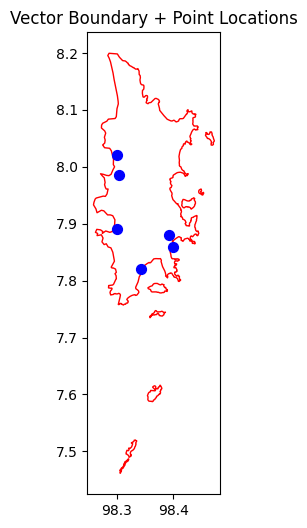

In [107]:
fig, ax = plt.subplots(figsize=(6,6))

phuket.plot(ax=ax, facecolor="none", edgecolor="red")
points.plot(ax=ax, color="blue", markersize=50)

plt.title("Vector Boundary + Point Locations")
plt.show()

In [108]:
import folium

# ใช้ points ตัวล่าสุด (ที่มี 6 จุด)
print("Total points =", len(points))

m = folium.Map(location=[7.92, 98.35], zoom_start=11)

# Phuket boundary
folium.GeoJson(
    phuket,
    name="Phuket Boundary",
    style_function=lambda x:{
        "color":"blue",
        "weight":2,
        "fillOpacity":0
    }
).add_to(m)

# Red points
for idx,row in points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=1,
        popup=row["name"]
    ).add_to(m)

# Fit zoom
bounds = phuket.total_bounds
m.fit_bounds([[bounds[1],bounds[0]],[bounds[3],bounds[2]]])

folium.LayerControl(collapsed=False).add_to(m)

m
m

Total points = 6


# **ผลการดำเนินงาน**

จากการประมวลผลข้อมูลเชิงพื้นที่ของจังหวัดภูเก็ต ได้ทำการนำเข้าข้อมูลภาพถ่ายดาวเทียม Sentinel-2 ในรูปแบบ Raster และข้อมูลขอบเขตพื้นที่ในรูปแบบ Vector เพื่อใช้ในการวิเคราะห์ร่วมกัน โดยเริ่มจากการตรวจสอบ Metadata ของภาพดาวเทียม เช่น ระบบพิกัด (CRS), ความละเอียดเชิงพื้นที่ และจำนวนแบนด์ ก่อนนำข้อมูลมาทำ Masking และ Clipping ให้เหลือเฉพาะพื้นที่จังหวัดภูเก็ต

ผลการแสดงผลภาพ RGB ที่ผ่านการปรับค่า Stretching แสดงให้เห็นลักษณะภูมิประเทศของพื้นที่อย่างชัดเจน โดยพื้นที่สีเขียวเข้มสื่อถึงบริเวณป่าไม้และพื้นที่ธรรมชาติ ส่วนพื้นที่สีอ่อนกระจายอยู่บริเวณเขตเมืองและชายฝั่ง จากนั้นได้ทำการแยก Band Red, Green และ Blue เพื่อแสดงองค์ประกอบของภาพถ่ายดาวเทียมตามที่กำหนดในหัวข้อการทำงานกับข้อมูล Raster

ในการวิเคราะห์ดัชนีพืชพรรณ (NDVI) ได้มีการโหลดข้อมูล NDVI และคำนวณค่าสถิติเบื้องต้น ได้แก่ ค่าเฉลี่ย (Mean ≈ 0.61), ค่าสูงสุด และค่าต่ำสุด ซึ่งสะท้อนว่าพื้นที่ส่วนใหญ่ของภูเก็ตมีค่าดัชนีพืชพรรณอยู่ในระดับปานกลางถึงสูง แสดงถึงการมีพืชพรรณค่อนข้างหนาแน่น โดยจากแผนที่ NDVI พบว่าพื้นที่สีเขียวครอบคลุมเกาะเป็นส่วนใหญ่ ขณะที่บริเวณที่ปรากฏสีแดงหรือค่าต่ำมักอยู่ในเขตเมือง ถนน หรือพื้นที่สิ่งปลูกสร้าง

นอกจากนี้ยังได้แสดงผลข้อมูล Digital Elevation Model (DEM) เพื่อวิเคราะห์ความสูงภูมิประเทศ พบว่าบริเวณตอนกลางของเกาะมีระดับความสูงมากกว่าชายฝั่ง ซึ่งสอดคล้องกับลักษณะภูมิประเทศจริงของภูเก็ตที่มีแนวเขากลางเกาะ

ในส่วนของข้อมูลเวกเตอร์ ได้สร้างจุดตำแหน่งสถานีตรวจวัดคุณภาพอากาศและนำมาแสดงร่วมกับขอบเขตจังหวัดทั้งในรูปแบบ Matplotlib และ Folium โดยแผนที่แบบ Interactive สามารถเปิด-ปิด Layer และแสดงชื่อสถานีเมื่อคลิกที่จุดได้ แสดงถึงการผสานข้อมูล Raster และ Vector เพื่อการวิเคราะห์เชิงพื้นที่อย่างครบถ้วน

โดยรวมแล้ว ผลลัพธ์ที่ได้สามารถแสดงภาพรวมของสภาพพื้นที่ ภูมิประเทศ และการกระจายตัวของพืชพรรณในจังหวัดภูเก็ตได้อย่างชัดเจน พร้อมทั้งแสดงตัวอย่างการประยุกต์ใช้เครื่องมือ Python ในการวิเคราะห์ข้อมูลภูมิสารสนเทศตามวัตถุประสงค์ของการทดลอง

# **คำถามท้าย Lab**

**1. ข้อดีและข้อเสียของการใช้ Matplotlib และ Folium ในการแสดงผลข้อมูลเชิงพื้นที่คืออะไร?**

จากการทำงานในโค้ด Lab นี้ พบว่า Matplotlib เหมาะสำหรับการแสดงผลเชิงวิเคราะห์ เช่น การแสดงค่า Band ต่าง ๆ ของภาพดาวเทียม การแสดง NDVI และ DEM พร้อม colorbar และการคำนวณค่าสถิติ เพราะสามารถควบคุมรูปแบบกราฟได้ละเอียด และเหมาะกับการใช้ในขั้นตอนวิเคราะห์ข้อมูลภายใน Notebook อย่างไรก็ตาม ข้อจำกัดคือไม่สามารถโต้ตอบกับแผนที่ได้ ผู้ใช้ไม่สามารถซูมหรือเปิด–ปิด Layer ได้แบบแผนที่จริง

ในขณะที่ Folium ถูกใช้ในโค้ดเพื่อสร้างแผนที่แบบ Interactive เช่น การแสดงขอบเขตภูเก็ตและตำแหน่งสถานีตรวจวัดอากาศด้วย CircleMarker ซึ่งสามารถซูม เลื่อน และเปิด LayerControl ได้ ทำให้เหมาะกับการนำเสนอผลลัพธ์เชิงแผนที่ ข้อเสียคือการวิเคราะห์เชิงตัวเลขหรือการปรับแต่งภาพเชิงลึกทำได้ยากกว่า Matplotlib


**2. ทำไมเราต้องใช้ Masking และ Clipping ในการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียม?**

ในโค้ดได้มีการใช้ rasterio.mask เพื่อตัดภาพ RGB ตามขอบเขตจังหวัดภูเก็ต (phuket.geometry) ซึ่งเป็นขั้นตอนสำคัญ เพราะภาพดาวเทียมมักมีพื้นที่กว้างกว่าบริเวณที่ต้องการศึกษา หากไม่ทำ Masking หรือ Clipping จะมีค่าพิกเซลที่อยู่นอกพื้นที่เข้ามารวมในการวิเคราะห์ ทำให้ผลลัพธ์คลาดเคลื่อน การตัดภาพช่วยลดข้อมูลส่วนเกิน ทำให้การคำนวณ NDVI และการแสดงผล RGB เหลือเฉพาะพื้นที่ศึกษา ช่วยให้การวิเคราะห์มีความแม่นยำและประหยัดทรัพยากรในการประมวลผลมากขึ้น

**3. ค่า NDVI บ่งบอกถึงอะไร? และสามารถใช้ NDVI ในการวิเคราะห์อะไรได้บ้าง?**

NDVI (Normalized Difference Vegetation Index) เป็นดัชนีที่ใช้วัดความเขียวหรือความหนาแน่นของพืชพรรณ โดยคำนวณจากความแตกต่างระหว่างแบนด์ Near-Infrared และ Red ค่า NDVI จะอยู่ระหว่าง -1 ถึง 1 ซึ่งค่าที่สูง (สีเขียวในแผนที่) หมายถึงพื้นที่ที่มีพืชพรรณสมบูรณ์ ส่วนค่าต่ำหรือค่าติดลบ (สีแดง) มักเป็นพื้นที่เมือง ดินเปล่า หรือแหล่งน้ำ

ใน Lab นี้ NDVI ถูกนำมาใช้เพื่อวิเคราะห์พื้นที่สีเขียวของจังหวัดภูเก็ต รวมถึงคำนวณค่าสถิติเบื้องต้น เช่น ค่าเฉลี่ย ค่าสูงสุด และค่าต่ำสุด ซึ่งสามารถนำไปใช้ติดตามการเปลี่ยนแปลงของป่าไม้ การใช้ที่ดิน หรือสุขภาพของพืชพรรณในระยะยาวได้


**4. การแปลงค่าพิกัด (CRS) มีความสำคัญอย่างไรในการทำงานกับข้อมูลเวกเตอร์และแรสเตอร์?**

ในโค้ดมีการใช้ to_crs() เพื่อแปลงค่าพิกัดของข้อมูลเวกเตอร์ให้ตรงกับ CRS ของภาพดาวเทียม ซึ่งเป็นขั้นตอนสำคัญมาก เพราะข้อมูลเวกเตอร์และแรสเตอร์อาจมีระบบพิกัดต่างกัน หากไม่แปลง CRS ก่อน การนำข้อมูลมาซ้อนกัน เช่น การ Mask หรือ Overlay จะเกิดการเลื่อนตำแหน่ง ทำให้ผลวิเคราะห์ผิดพลาด การทำ CRS ให้ตรงกันจึงช่วยให้ขอบเขตภูเก็ต จุดสถานี และภาพดาวเทียมแสดงตรงตำแหน่งเดียวกันอย่างถูกต้อง

**5. หากต้องการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียมในช่วงเวลาต่าง ๆ (Time Series) ควรทำอย่างไร?**

หากต้องการวิเคราะห์ Time Series ควรเตรียมภาพดาวเทียมหลายช่วงเวลา เช่น Sentinel-2 หลายวันหรือหลายเดือน จากนั้นนำแต่ละภาพมาผ่านขั้นตอนเดียวกับใน Lab นี้ ได้แก่ การปรับ CRS การ Masking/Clipping และการคำนวณ NDVI หรือดัชนีอื่น ๆ แล้วนำค่าที่ได้มาเปรียบเทียบตามช่วงเวลา อาจสร้างกราฟแนวโน้มค่า NDVI หรือสร้างแผนที่หลาย Layer ใน Folium เพื่อดูการเปลี่ยนแปลงของพื้นที่สีเขียวหรือสภาพภูมิประเทศตามเวลา วิธีนี้ช่วยให้สามารถติดตามการเปลี่ยนแปลงสิ่งแวดล้อม เช่น การขยายตัวของเมือง การฟื้นตัวของป่า หรือผลกระทบจากภัยพิบัติได้อย่างมีประสิทธิภาพ